In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
from scipy import interpolate, stats

In [104]:
import ProcessOT2DOE as process
import CreateSamples

# Step 1: Load Sample Information
* Will be in the form of a dataframe. This dataframe should be standardized in the original documentation.
* Either load locally or pull from the google drive.

In [105]:
sample_info = pd.read_csv(r"C:\Users\Edwin\Downloads\Experiment Synthesis Info")

# Step 2: Load UV-Vis Date
* ***If loading from plate reader***: Once the plate has been read, allow for exporting to an excel sheet and reformat for easy upload and merging.
    * The plate reader should automatically ask you if you would like to export to excel. When running multiple plates you can just keep selecting export and it will automatically add the new run as an additional sheet to the originally generated excel sheet. 
    * To format for easy loading:
        1. Create a new sheet in the same exported excel file and name it something simple (i.e. sheet1). 
        2. Copy the data from the sheet and add it to the newly created sheet. **NOTE**: Make sure to paste in the data as "only values". 
        3. Repeat for every single exported sheet (i.e. every plate)
* ***If loading from single cuvette reader***: 

* issue when over scanned on accident 

In [106]:
def merge_wavelength_dfs(df_list):
    merge_list = []
    for i, df in enumerate(df_list):
        if i == 0:
            df = df
        else: 
            df = df.drop(['Wavelength'])
        print(len(df))
        merge_list.append(df)
    return pd.concat(merge_list)

In [107]:
def detect_ovflw(df, holder=15):
    hold_index = df.index
    
    df = df.copy() # Setting up to prevent any errors
    df.reset_index(drop=True, inplace=True)

    for name, row in df.iterrows():
        row = list(row)
        if 'OVRFLW' in row: 
            row = [holder if value == 'OVRFLW' else value for value in row]
            df.loc[name] = row
        else:
            df.loc[name] = row
    df.index = hold_index
    
    return df

In [117]:
path = r"C:\Users\Edwin\Downloads\03_03_21_Left_Robot.xlsx"
plate_names = ['Sheet1','Sheet2','Sheet3']
plate_dfs = process.extract_plates(path, plate_names) # can edit/remove wells accidently measured etc, but really should be done at excel level
merged_df = process.merge_wavelength_dfs(plate_dfs) # a check
merged_df = merged_df[:125] # since should be length n of sample info + 1 (wavelength)

In [118]:
abs_df = detect_ovflw(merged_df, holder = 30)
abs_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Wavelength,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900
A1,3.48,3.738,0.778,0.328,0.056,0.048,0.045,0.045,0.045,0.043,0.043,0.044,0.044,0.044,0.054
A2,3.492,3.734,0.809,0.352,0.078,0.062,0.053,0.049,0.047,0.045,0.044,0.055,0.052,0.061,0.095
A3,3.477,3.72,0.719,0.312,0.079,0.066,0.056,0.053,0.051,0.048,0.047,0.056,0.054,0.061,0.098
A4,3.46,3.715,0.661,0.276,0.063,0.052,0.047,0.045,0.043,0.041,0.041,0.049,0.048,0.054,0.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C8,3.459,3.698,0.641,0.259,0.049,0.04,0.037,0.037,0.038,0.037,0.038,0.049,0.047,0.055,0.09
D1,3.474,3.726,0.707,0.29,0.051,0.042,0.041,0.041,0.04,0.038,0.037,0.046,0.045,0.051,0.089
D2,3.462,3.699,0.628,0.256,0.05,0.041,0.041,0.038,0.04,0.04,0.039,0.046,0.044,0.049,0.091
D3,3.456,3.711,0.621,0.251,0.049,0.043,0.038,0.038,0.04,0.038,0.037,0.043,0.044,0.049,0.093


In [119]:
samples = abs_df[1:63].copy()
samples.reset_index(drop=True, inplace=True)
blanks = abs_df.copy()[63:]
blanks.reset_index(drop=True, inplace=True)

blanked_samples = samples-blanks
blanked_samples

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.018,0.002,0.094,0.053,0.004,0.006,0.004,0.003,0.004,0.004,0.006,0.007,0.007,0.007,0.005
1,0.031,0.068,0.098,0.063,0.025,0.016,0.009,0.006,0.003,0.002,0.001,-0.001,-0.001,-0.001,-0.001
2,0,-0.019,-0.067,-0.011,0.028,0.024,0.016,0.012,0.01,0.007,0.006,0.004,0.004,0.003,0.004
3,-0.012,-0.019,-0.079,-0.024,0.01,0.009,0.006,0.002,0.001,0,0.001,0.001,0.002,0.002,0.003
4,-0.002,-0.001,-0.024,-0.005,0.003,0.001,0.001,0.005,0.003,-0.001,-0.003,-0.003,-0.001,0.002,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.028,0.045,0.148,0.076,0.027,0.021,0.018,0.015,0.012,0.01,0.007,0.005,0.004,0.003,0.004
58,-0.001,0.011,0.02,0.012,0.019,0.014,0.011,0.009,0.006,0.005,0.006,0.008,0.008,0.008,0.007
59,-0.004,0.021,0.068,0.021,0.002,0.001,0,0.003,-0.002,-0.003,-0.001,0.003,0.004,0.004,0.004
60,0.001,0.018,0.063,0.022,0.002,-0.002,0,0,-0.002,-0.002,-0.001,0,-0.002,-0.003,-0.007


In [120]:
# there is an issue I noticed when calling a well, if use multiple plates will call more than one well
# just temporarily save index, reset index then put back

(-0.15, 0.2)

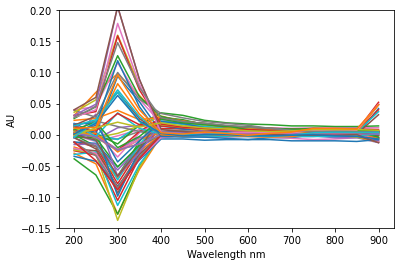

In [125]:
# abs_df.drop(['Wavelength'], inplace=True)
for name, row in blanked_samples.iterrows():
    plt.plot(wavelengths, row)
    
plt.xlabel('Wavelength nm')
plt.ylabel('AU')
plt.ylim(-0.15,0.20)

# Step 2: Select/Locate Blank 
* ***If loading from plate reader***: Once the plate has been read, allow for exporting to an excel sheet and reformat for easy upload and merging.
    * The plate reader should automatically ask you if you would like to export to excel. When running multiple plates you can just keep selecting export and it will automatically add the new run as an additional sheet to the originally generated excel sheet. 
    * To format for easy loading:
        1. Create a new sheet in the same exported excel file and name it something simple (i.e. sheet1). 
        2. Copy the data from the sheet and add it to the newly created sheet. **NOTE**: Make sure to paste in the data as "only values". 
        3. Repeat for every single exported sheet (i.e. every plate)
* ***If loading from single cuvette reader***: 

In [84]:
def add_abs_to_sample_info(sample_info_df, abs_df):
    
    wavelengths = list(abs_df.loc['Wavelength'])
    wavelengths_names = [str(wavelength)+'nm' for wavelength in wavelengths]
    abs_df.columns = wavelengths_names
    abs_df.drop(['Wavelength'], inplace=True)

    
    
    sample_info_df.reset_index(drop=True, inplace=True)
    abs_df.reset_index(drop=True, inplace=True)
    combined_df = pd.concat([sample_info_df, abs_df], axis = 1)
    return combined_df

In [96]:
abs_df = merged_df.copy()
wavelengths = list(abs_df.loc['Wavelength'])
wavelengths_names = [str(wavelength)+'nm' for wavelength in wavelengths]
abs_df.columns = wavelengths_names
abs_df.drop(['Wavelength'], inplace=True)

In [97]:
sample_info.reset_index(drop=True, inplace=True)
abs_df.reset_index(drop=True, inplace=True)
combined_df = pd.concat([sample_info, abs_df], axis = 1)
combined_df

,UID,dppc wtf,dspepeg200 wtf,pfh wtf,ethanol wtf,water wtf,Well,Labware,Slot,200nm,...,450nm,500nm,550nm,600nm,650nm,700nm,750nm,800nm,850nm,900nm
0,S2_A1_05-03-2021_Right,0.0001,0.000035,0.0,0.222222,0.777643,A1,Falcon 48 Well Plate 1500 ÂµL,2,3.492,...,0.044,0.042,0.043,0.042,0.041,0.04,0.043,0.042,0.042,0.053
1,S2_A2_05-03-2021_Right,0.0001,0.000035,0.0,0.333333,0.666532,A2,Falcon 48 Well Plate 1500 ÂµL,2,3.502,...,0.057,0.05,0.047,0.045,0.042,0.042,0.054,0.051,0.061,0.096
2,S2_A3_05-03-2021_Right,0.0001,0.000035,0.0,0.444444,0.555421,A3,Falcon 48 Well Plate 1500 ÂµL,2,3.508,...,0.065,0.059,0.055,0.052,0.05,0.049,0.06,0.058,0.065,0.103
3,S2_A4_05-03-2021_Right,0.0001,0.000035,0.0,0.555556,0.444309,A4,Falcon 48 Well Plate 1500 ÂµL,2,3.482,...,0.053,0.048,0.045,0.044,0.041,0.041,0.05,0.049,0.055,0.097
4,S2_A5_05-03-2021_Right,0.0001,0.000035,0.0,0.666667,0.333198,A5,Falcon 48 Well Plate 1500 ÂµL,2,3.459,...,0.042,0.041,0.039,0.037,0.037,0.039,0.05,0.049,0.053,0.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,S5_C8_05-03-2021_Right,0.0000,0.000000,0.0,0.445579,0.554421,C8,Falcon 48 Well Plate 1500 ÂµL,5,3.471,...,0.04,0.037,0.038,0.038,0.038,0.038,0.049,0.047,0.054,0.09
120,S5_D1_05-03-2021_Right,0.0000,0.000000,0.0,0.556691,0.443309,D1,Falcon 48 Well Plate 1500 ÂµL,5,3.479,...,0.043,0.039,0.038,0.038,0.038,0.038,0.048,0.047,0.054,0.092
121,S5_D2_05-03-2021_Right,0.0000,0.000000,0.0,0.667802,0.332198,D2,Falcon 48 Well Plate 1500 ÂµL,5,3.471,...,0.042,0.04,0.041,0.042,0.04,0.039,0.046,0.044,0.048,0.088
122,S5_D3_05-03-2021_Right,0.0000,0.000000,0.0,0.778913,0.221087,D3,Falcon 48 Well Plate 1500 ÂµL,5,3.469,...,0.052,0.047,0.046,0.048,0.047,0.047,0.055,0.052,0.054,0.098


In [98]:
combined_df_csv = combined_df.to_csv(r"hold", index=False)

In [99]:
CreateSamples.team_drive_dict()

{'Website': '1tmTZGkxJSvWx_6BCMXrkTVrVOv6tyBNy',
 'Photos': '1jzn8Kco19sOZOX_ylvfXaXPDuyUhxeO6',
 'Scattering Data (Zip)': '1mK7Ng9JN7QPdil97V0Qs-OD-K-_7FdnR',
 'Current Members': '1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64',
 'Past Members': '1Vtib8bQXDWq0YcCTa2pfsdQg0TiDIo4e',
 'Outreach': '1wFNFEO_Oh3ofvs_r_MU1srYby5g8MlTN',
 'Lab Management': '1JO0pqhlxXKP-daj7q_vVuby_eAdqjS38',
 'Papers and Presentations': '1HPSkjct2rMuef-M7YVd1gbNM8vXNy4zp',
 'Collaborations': '1QNbjvEZRtFk4ftQFPWzt8kogPmvlYUc0'}

In [100]:
current_members = CreateSamples.file_and_folder_navi('1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64')
CreateSamples.file_and_folder_navi('1CDnoLE32bG0BFhhvCl5JlRFO4I_ga-eJ')

{'03_03_21_Rescan': '1YdAqr1kYFEuRc8wyd9dcyzo0BWW68-1P',
 '03_03_21_RightRobot': '1YXrIIXT3uSFd5-NSpht-1wB1-7hH6Y1w',
 '03_03_21_LeftRobot': '1gQQcekJQfe4Ktvc-IrEqeNtIUbyRJIbl',
 '02_26_21_Ethanol_Water_Standards': '16UECO_E7-7y37vnmqMmnFf7haZC8h8jZ',
 '02_26_21_OuzoScan': '19v4-bQnGwFyxoRpQAggCjAC4tgGVH7Fd',
 '02_25_21_Reproducibility': '1Odb3xLOVqxpzlqBsefW9zJ6Ls80k3wRC',
 '02_17_21_Reproducibility': '14EQgsamEwie--wmwaXQgVUTuqYbn52ve',
 '02_24_21_Reproducibility': '1YV8tpbj6mhWYJDkiQzOOHgGM4wPgjaxX'}

In [101]:
synthesis_info_file_path = r"hold"
folder_to_place_id = '1YXrIIXT3uSFd5-NSpht-1wB1-7hH6Y1w'

CreateSamples.upload_to_team_drive_folder(folder_to_place_id, synthesis_info_file_path, 'Synthesis and UVVis')

In [ ]:
test_open = pd.read_csv(r"C:\Users\Edwin\Desktop\11_18_2020\11_18_20_merged_info")
test_open

In [ ]:
# extract data by dict method of df calling series
wavelength = '400.0nm'
x_name = combined_df['Component 4 wtf'][0]
y_name = combined_df['Component 3 wtf'][0]
x = [float(i) for i in combined_df['Component 4 wtf'][1:].tolist()][:-1] #ethanol, 
y = [float(i) for i in combined_df['Component 3 wtf'][1:].tolist()][:-1] # pfh
z = [float(i) for i in combined_df[wavelength][1:].tolist()][:-1]
combined_restricted_xyz = [x,y,z]
modi = remove_visual_outliers(x,y,z,2) # this should only be used to find the new vmin and vmax but not to exclude